<p align="center"><center>
  <img width="800" height="800" src="https://www.retaildetail.be/sites/default/files/news/shutterstock_353631137_0.jpg">
    </center></p>


Le service marketing de Walmart nous demande de construire un modèle d'apprentissage automatique capable d'estimer les ventes hebdomadaires dans leurs magasins. Un tel modèle les aiderait à mieux comprendre comment les ventes sont influencées par les indicateurs économiques et pourraient être utilisées pour planifier de futures campagnes marketing.

In [1]:
!pip install plotly==5.0.0 -q
!pip install missingno -q
%matplotlib inline 
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import sklearn
from numpy import arange
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, Lasso
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV,train_test_split
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve,mean_squared_error ,r2_score,mean_absolute_error
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly.graph_objects as go, plotly.express as px, plotly.io as pio
import statsmodels.api as st
import matplotlib.pyplot as plt
import plotly.express as px

pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE

In [2]:
dataset = pd.read_csv('Walmart_Store_sales.csv')

Number de lignes et de colonnes : (150, 8)

Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

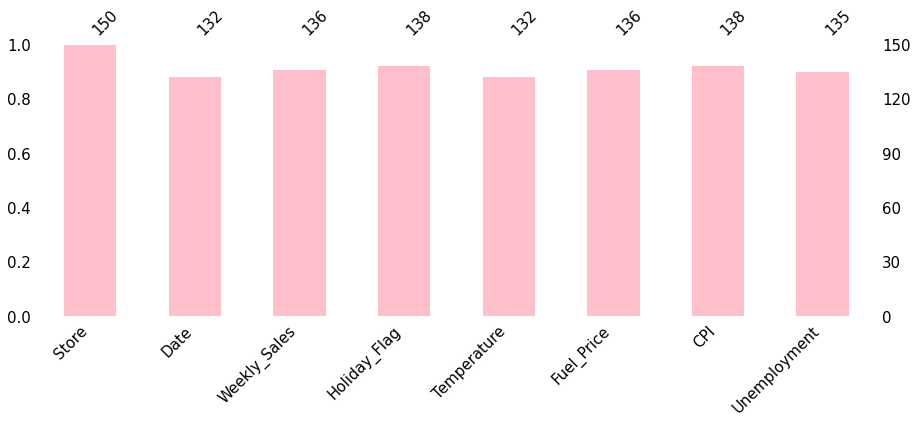

In [3]:
# Basic stats
print("Number de lignes et de colonnes : {}".format(dataset.shape))
print()


print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

import missingno as msno
msno.bar(dataset,figsize=(15, 5),fontsize=15,color='pink');

Toutes les colonnes ont très peu de valeurs manquantes.

In [4]:
#on supprime les valeurs manquantes pour la colonne Weekly_Sales
index_avec_nan = dataset.index[dataset.iloc[:,2].isnull()]
dataset.drop(index_avec_nan,0, inplace=True)

In [5]:
dataset['semaine'] =pd.to_datetime(dataset['Date']).dt.isocalendar().week
dataset['année'] = pd.to_datetime(dataset['Date']).dt.isocalendar().year
dataset['mois'] = pd.to_datetime(dataset['Date']).dt.month
dataset['true_date'] = pd.to_datetime(dataset['Date'])
dataset['true_date'].sort_values()

#pour convertir la température en degrés c°
dataset['Temperature'] = ((dataset['Temperature'])-32)/1.8

In [6]:
fig = px.scatter(dataset, x='Temperature',y='Weekly_Sales', color='Store');
#fig.show()

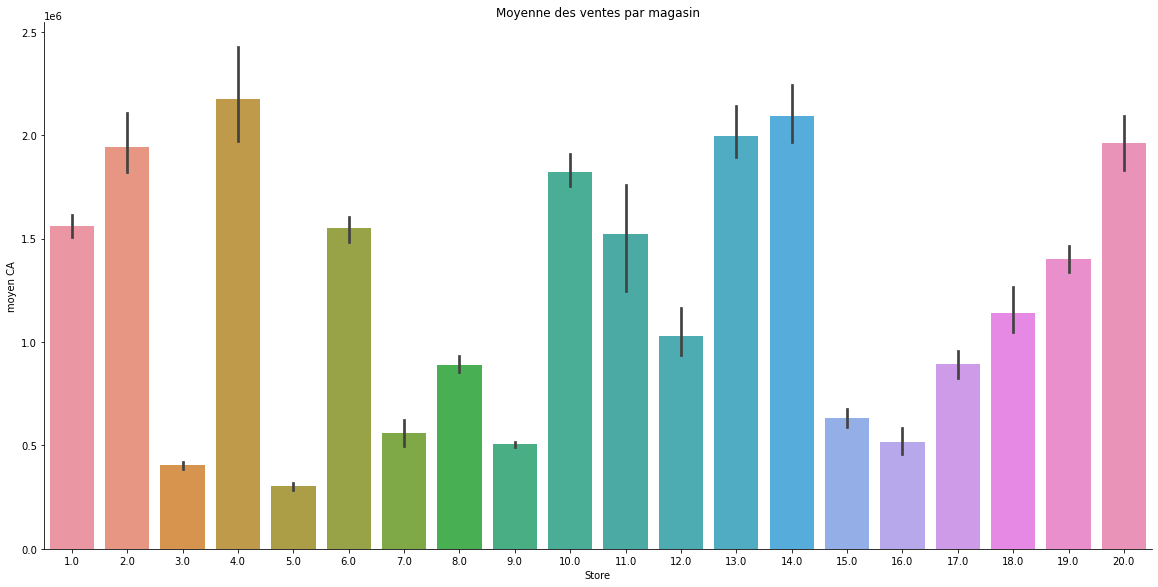

In [7]:
g1 = dataset.groupby("Weekly_Sales")['Store'].mean().reset_index()

ax = sns.catplot( x="Store",y='Weekly_Sales',data = g1, kind='bar',
                    height=8,
                    aspect=2)
ax.set(title='Moyenne des ventes par magasin', xlabel="Store", ylabel="moyen CA")
plt.show;

Text(0.5, 1.0, 'Moyenne des ventes par mois et par années')

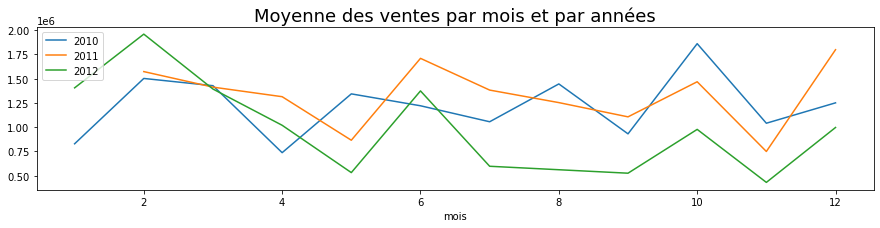

In [8]:
plt.figure(figsize=(15,3))
dataset[dataset['année']==2010].groupby('mois')['Weekly_Sales'].mean().plot()
dataset[dataset['année']==2011].groupby('mois')['Weekly_Sales'].mean().plot()
dataset[dataset['année']==2012].groupby('mois')['Weekly_Sales'].mean().plot()
plt.legend(['2010', '2011', '2012'], fontsize=10)
plt.title('Moyenne des ventes par mois et par années', fontsize=18)

Ce graphique nous permet de visualiser les ventes sur 3 années consécutives et met en avant les pîques d'affluences communs. Il nous permet également de constater des différences de résultats en fonction des années pouvant être liés à plusieurs facteurs. 

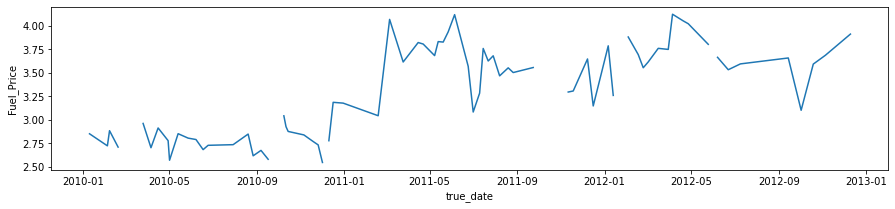

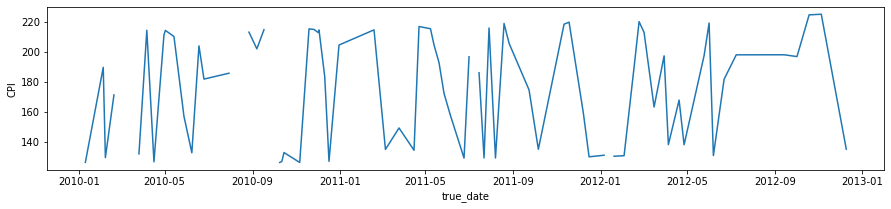

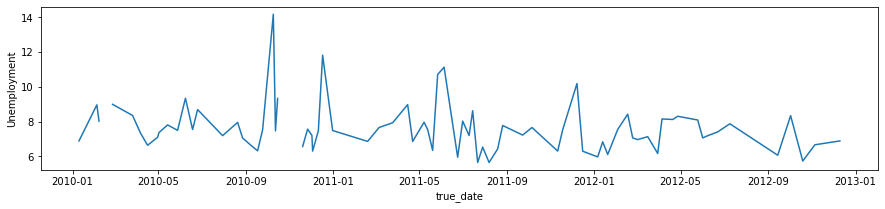

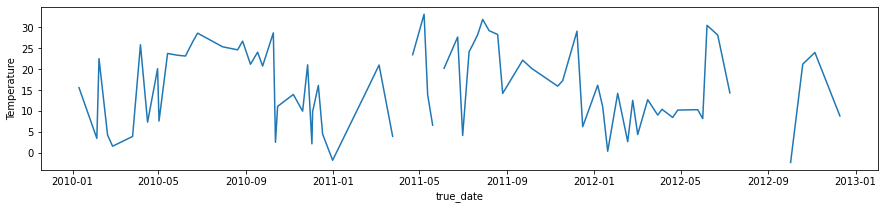

In [9]:
def plt_figure (variable):
    plt.figure(figsize=(15,3))
    dataset.groupby('true_date')[variable].mean().plot(subplots=True, figsize=(20,15));
    plt.ylabel(variable)
    
plt_figure('Fuel_Price')
plt_figure('CPI')
plt_figure('Unemployment')
plt_figure('Temperature')

On constate que les ventes varient en fonction de la température et particulièrement lorsque les températures sont basses. 
On remarque également que le prix du fuel est en constante augmentation. l'indice des prix à la consomation quant à lui varie en fonction du temps tout comme la température qui varie en fonction des saisonnalités.
On observe également que le taux de chômage diminue sur le temps.

In [10]:
print('Nombre de ligne ',dataset[:].shape [0])
liste_col = ('Temperature','Fuel_Price','CPI','Unemployment')
for element in liste_col:
    borne_inf = dataset[element].mean() - 3 *dataset[element].std() 
    borne_sup = dataset[element].mean() + 3 *dataset[element].std()
    mask = ((dataset[element] < borne_inf) | (dataset[element] > borne_sup))
    print(mask.sum())
    dataset2 = dataset.loc[~mask,:]
print('Nombre de ligne ',dataset2[:].shape [0])

Nombre de ligne  136
0
0
0
5
Nombre de ligne  131


Nous supprimons les valeurs aberrantes qui ne tombent pas dans l'intervalle : [𝑋¯−3𝜎,𝑋¯+3𝜎] .
En machine learning toutes les valeurs en dehors sont des outliers. On les supprime afin d'éviter de fausser l'apprentissage.

# Régression linéaire

In [11]:
# sépare nos variables Y et X
features_list = ["Store","Holiday_Flag","Temperature","Fuel_Price","CPI","Unemployment"]
target_variable = "Weekly_Sales"

X = dataset2.loc[:,features_list]
Y = dataset2.loc[:,target_variable]

# Divide dataset Train set & Test set 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    random_state=0)

# convertir les Datafram en numpy avant d'utiliser scikit-learn
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.tolist()
Y_test = Y_test.tolist()


# Create pipeline for categorical features
numeric_features = [2,3,4,5]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values in Age will be replaced by columns' mean
    ('scaler', StandardScaler())])

# Create pipeline for categorical features
categorical_features = [0, 1]
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first'))]) # first column will be dropped to avoid creating correlations between features

# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set on utilise .todense 
# pour éviter de transformer notre variable en sparce matrix
X_train = preprocessor.fit_transform(X_train)
X_train = X_train.todense()
#Preprocessings on test set
X_test = preprocessor.transform(X_test)
X_test = X_test.todense()

# Encoding categorical features and standardizing numerical features

# Train model
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

# Predictions on training set
Y_train_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)

# calcule des métriques d'évaluation 
coef = regressor.coef_
rmse = (np.sqrt(mean_squared_error(Y_train, Y_train_pred)))
mape = np.mean(np.abs((Y_train - Y_train_pred) / Y_train)) * 100
SST = np.sum(np.square(Y_train- np.mean(Y_train)))
SSE = np.sum(np.square(regressor.predict(X_train) - np.mean(Y_train)))
SSR = np.sum(np.square(Y_train - regressor.predict(X_train)))
R_2 = 1 - SSR/SST
R_2_alt = regressor.score(X_train,Y_train) 
n = X.shape[0]
p = X.shape[1]
R_2_adj = 1 - (n-1)/(n-p-1)*(1-R_2)

# les métriques d'évaluation
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))
print("\n")
print('root mean square error :', rmse)
print('mean absolute percentage error :' ,mape)
print("\n")
#print('on prédit un CA moyen pour les 20 magasins de  :', np.mean(Y_test))
#print('on prédit un CA moyen pour les 20 magasins sur le pred de :',np.mean(Y_test_pred))
#print('le coeficients de prediction est de :',np.mean(coef))
#print("\n")
#print("SST : Sum of Square Total {}".format(SST))
#print("SSE : Sum of Square Explained {}".format(SSE))
#print("SSR : Sum of Square Residual {}".format(SSR))
#print("\n")
#print("R square {}".format(R_2))
#print("R square {}".format(R_2_alt))
#print("R square adjusted {}".format(R_2_adj))

R2 score on training set :  0.9629121558724477
R2 score on test set :  0.9390204016214599


root mean square error : 127100.96458261933
mean absolute percentage error : 7.579988263981298




On constate que nous avons un très bon score sur le test et sur le train qui est de 94%.
Notre model arrive donc à bien prédire notre variable cible.
On constate également que notre mean absolute pourcentage error estime la valeur d'erreur dans les prédictions et celle-ci est de 7,57% soit 127 100 dollars sur nos Weekly_Sales.

# GridSearch


In [12]:
regressor = Ridge()
scores = cross_val_score(regressor, X_train, Y_train, cv=3)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

params = {
    'alpha': [0.0,0.001,0.01,0.04,0.1, 0.2, 0.3, 0.4,0.7]}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 5) #verbose = 2 pour voir l'entrainement pour chaques param

gridsearch.fit(X_train, Y_train)
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

# Predictions on training set
Y_train_pred = gridsearch.predict(X_train)
Y_test_pred = gridsearch.predict(X_test)
print("\n")
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

The cross-validated R2-score is :  0.8251329664383147
The standard deviation is :  0.037962560529014804
Best hyperparameters :  {'alpha': 0.0}
Best R2 score :  0.9380817703030605


R2 score on training set :  0.9629121558724478
R2 score on test set :  0.9390204016214598


Le score de la cross-validation diminue, avec une standard déviation à 0.037 qui represente, la moyenne des écarts des données par rapport à leur moyenne, ce qui limite les erreurs. Plus un écart type est faible, plus mes données seront moins dispersées et seront donc regroupées autour de la moyenne.
Avec notre model Gridsearch on constate que le R2 augmente légèrement. Le model Gridsearch est parfait pour éviter l'overfiting.

# Lasso

In [13]:
reg = LassoCV(cv=3, random_state=0)
reg.fit(X_train,Y_train)

Y_train_pred = reg.predict(X_train)
Y_test_pred = reg.predict(X_test)
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

rmse = (np.sqrt(mean_squared_error(Y_train, Y_train_pred)))
mape = np.mean(np.abs((Y_train - Y_train_pred) / Y_train)) * 100

print("\n")
print('root mean square error :', rmse)
print('mean absolute percentage error :' ,mape)

features = list(preprocessor.transformers_[1][1]['encoder'].get_feature_names())
num_var = ['Temperature','Fuel_Price','CPI','Unemployment']
Z = features + num_var
Z = pd.DataFrame(Z) 
coef = pd.DataFrame(reg.coef_,columns=['coef'])
coeff = pd.concat([Z,coef],axis=1)
coeff.groupby(['coef']).sort


df = pd.DataFrame({
            "Parameter":reg.coef_[reg.coef_!=1]})

coef_variable = pd.concat([Z,df],axis=1)
#print(coef_variable)

R2 score on training set :  0.961930080697494
R2 score on test set :  0.9413505709163408


root mean square error : 128772.76770853215
mean absolute percentage error : 7.5267770865028085


Pour le modèle LASSO quand à lui nous donne de meilleures pérformances sur le R2 score du test avec 94%.

In [14]:
coef_num = pd.DataFrame(index =liste_col, data = { 'coefficients' : reg.coef_[0:4],
                                                  #'pvalues' : ols_fit.pvalues[1:5] }
                                                }).sort_values("coefficients")
coef_num

,coefficients
Unemployment,-43750.888111
Fuel_Price,-39052.008506
Temperature,-25212.687117
CPI,44236.516376


In [15]:
coef_cat = pd.DataFrame(index =features, data = { 'coefficients' : reg.coef_[4:24],
                                                 #'pvalues' : ols_fit.pvalues[5:26] }
                                                }).sort_values(by = "coefficients")
df3 = pd.concat([coef_num,coef_cat])
coef_cat

,coefficients
x0_5.0,-1.245417e+06
x0_3.0,-1.134884e+06
x0_9.0,-1.078398e+06
x0_16.0,-1.012581e+06
x0_7.0,-9.241626e+05
x0_15.0,-7.238281e+05
x0_8.0,-6.463542e+05
x0_17.0,-5.536305e+05
x0_18.0,-1.957781e+05
x1_1.0,0.000000e+00


In [16]:
df4 = df3.sort_values(["coefficients"])
px.bar(df4, x = 'coefficients', y = df4.index)

Les coefficients décrivent les relations des variables entre elles, elles nous montrent l'importance des variables par rapport à notre variable cible "Y".

Nous regardons maintenant graphiquement l'impact de nos variables par rapport à notre variable prédictive. On remarque que la variable CPI ainsi que les stores 11,2,20,10,13,14,4 ont un impact positif pour notre prédiction contrairement aux autres variables qui ont un impact négatif, on remarque aussi que les stores 6,19 et Holidays n'ont aucun impact sur notre variable car le coefficient est à 0.

In [17]:
df4 = df4.apply(lambda x : abs(x)).sort_values(by="coefficients", ascending=True)
px.bar(df4, x = 'coefficients', y = df4.index)

Nous regardons maintenant les coefficients en valeurs absolue pour mieux visualiser les variables les plus influentes.

Les stores sont indéniablement les plus influents


Text(0.5, 0, 'mois')

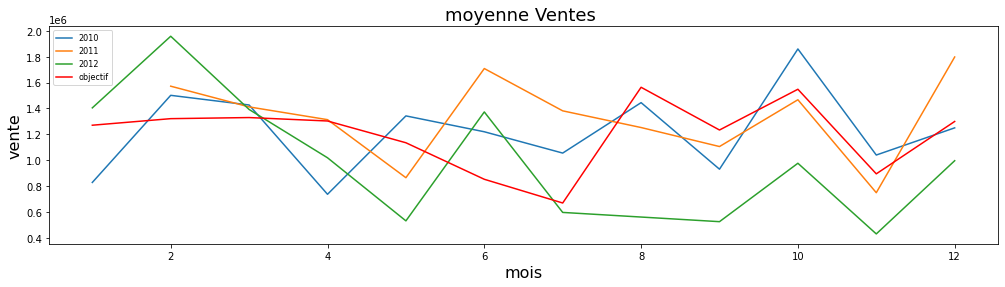

In [18]:
preddi = pd.DataFrame(Y_test_pred)
predi = pd.DataFrame(Y_train_pred)
prediction = preddi.append(predi)
prediction.columns = ['prediction']
plt.figure(figsize=(17,4))
dataset[dataset['année']==2010].groupby('mois')['Weekly_Sales'].mean().plot()
dataset[dataset['année']==2011].groupby('mois')['Weekly_Sales'].mean().plot()
dataset[dataset['année']==2012].groupby('mois')['Weekly_Sales'].mean().plot()
prediction.groupby(dataset['mois'])['prediction'].mean().plot(color='red')
plt.title('moyenne Ventes ', fontsize=18)
plt.legend(['2010', '2011', '2012','objectif'], fontsize=8)
plt.ylabel('vente', fontsize=16)
plt.xlabel('mois', fontsize=16)

Nous pouvons maintenant établir les objectifs des ventes grâce à notre prédiction.
On peut voir que les objectifs suivent bien les courbes des ventes des années prédentes et non pas été établies simplement avec une augmentation de 10% comme peuvent le faire certaines entreprises.

# Conclusion 

On constate que nos modèles sont assez bons pour prédire les ventes hebdomadaires. Même lorsque nous appliquons des techniques de régularisation pour lutter contre le surapprentissage. 
Notre meilleur modèle est le Lasso avec un score de 0.96 sur le train et 0.94 sur le test.
Il obtient le meilleur résultat et permet de bien prédire en cas d'entraînement avec des nouvelles données.
Les scores des autres modèles se jouent de peu mais ils ne sont pas très éloquents dû à la petite base de données que nous avons. 
On aperçoit également que la courbe de notre prédiction à l'air de bien se comporter. Pour optimiser le résultat de la prédiction il est important de renseigner de nouvelles données au fur et à mesure afin d'ajuster les résultats.

In [19]:
predi.to_csv('prédiction.csv',index=False)